In [12]:
%pip install rdkit


In [13]:
pip install pandas numpy scikit-learn matplotlib torch rdkit


[16:59:15] SMILES Parse Error: syntax error while parsing: Cc1cc(ccc1[N+](=O)[Or])C(=O)NCCc2c([nH]c3c2cccc3)C
[16:59:15] SMILES Parse Error: check for mistakes around position 21:
[16:59:15] Cc1cc(ccc1[N+](=O)[Or])C(=O)NCCc2c([nH]c3
[16:59:15] ~~~~~~~~~~~~~~~~~~~~^
[16:59:15] SMILES Parse Error: extra open parentheses while parsing: Cc1cc(ccc1[N+](=O)[Or])C(=O)NCCc2c([nH]c3c2cccc3)C
[16:59:15] SMILES Parse Error: check for mistakes around position 6:
[16:59:15] Cc1cc(ccc1[N+](=O)[Or])C(=O)NCCc2c([nH]c3
[16:59:15] ~~~~~^
[16:59:15] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(ccc1[N+](=O)[Or])C(=O)NCCc2c([nH]c3c2cccc3)C' for input: 'Cc1cc(ccc1[N+](=O)[Or])C(=O)NCCc2c([nH]c3c2cccc3)C'
[16:59:15] SMILES Parse Error: syntax error while parsing: Cc1c(cccc1OCc2ccccc2)[N+](=O)[Or]
[16:59:15] SMILES Parse Error: check for mistakes around position 32:
[16:59:15] Cc2ccccc2)[N+](=O)[Or]
[16:59:15] ~~~~~~~~~~~~~~~~~~~~^
[16:59:15] SMILES Parse Error: Failed parsing SMILES 'Cc1c(cccc1OCc2ccccc2

PGM Model — R²: 0.60, MSE: 0.57, Accuracy: 0.54


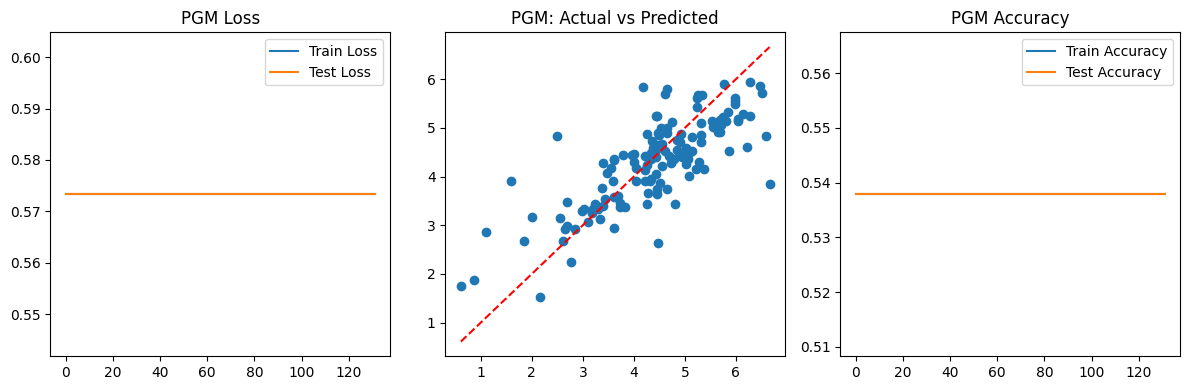

GNN Model — R²: 0.64, MSE: 0.52, Accuracy: 0.54


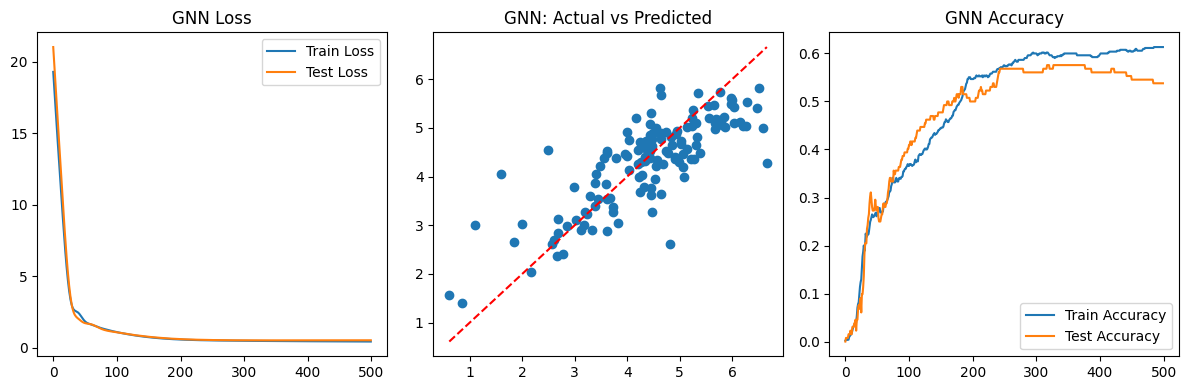

PGM+GNN Model — R²: 0.66, MSE: 0.49, Accuracy: 0.55


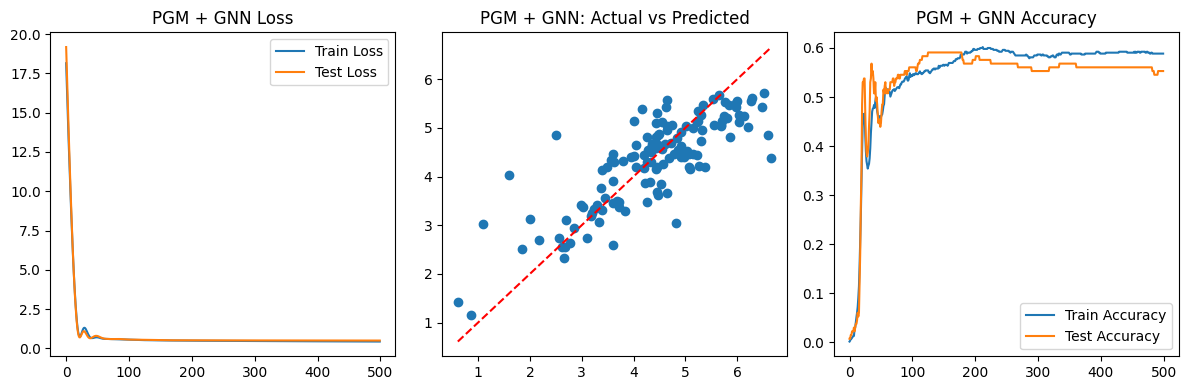

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from rdkit import Chem
from rdkit.Chem import Descriptors

# Load dataset
data = pd.read_csv("logP_experimental_dataset.csv")

# Convert logP to float
data['exp'] = pd.to_numeric(data['exp'], errors='coerce')

# Compute descriptors
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [np.nan] * 6
    return [
        Descriptors.MolWt(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.MolLogP(mol)
    ]

descriptor_list = [compute_descriptors(s) for s in data['slimp']]
X = np.array(descriptor_list)

# Filter invalid rows
data['valid'] = ~np.isnan(X).any(axis=1)
filtered_data = data[data['valid'] & data['exp'].notnull()]
X = X[filtered_data.index]
y = filtered_data['exp'].astype(float).values

# Normalize and split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Accuracy threshold
accuracy_threshold = 0.5

# Define plot function
def plot_results(model_name, y_test, preds, train_losses, test_losses, train_accuracies, test_accuracies):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.title(f"{model_name} Loss")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.scatter(y_test, preds)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.title(f"{model_name}: Actual vs Predicted")

    plt.subplot(1, 3, 3)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(test_accuracies, label="Test Accuracy")
    plt.title(f"{model_name} Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Step 1: PGM Model
pgm_model = BayesianRidge()
pgm_model.fit(X_train, y_train)
pgm_preds = pgm_model.predict(X_test)
pgm_r2 = r2_score(y_test, pgm_preds)
pgm_mse = mean_squared_error(y_test, pgm_preds)
pgm_accuracy = np.mean(np.abs(pgm_preds - y_test) < accuracy_threshold)
print(f"PGM Model — R²: {pgm_r2:.2f}, MSE: {pgm_mse:.2f}, Accuracy: {pgm_accuracy:.2f}")
plot_results("PGM", y_test, pgm_preds, [pgm_mse]*len(y_test), [pgm_mse]*len(y_test), [pgm_accuracy]*len(y_test), [pgm_accuracy]*len(y_test))

# Step 2: GNN Model (PyTorch MLP)
class GNN(nn.Module):
    def __init__(self, input_dim):
        super(GNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

device = torch.device("cpu")
X_train_t = torch.tensor(X_train, dtype=torch.float32, device=device)
X_test_t = torch.tensor(X_test, dtype=torch.float32, device=device)
y_train_t = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1, 1)
y_test_t = torch.tensor(y_test, dtype=torch.float32, device=device).view(-1, 1)

gnn_model = GNN(input_dim=X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

epochs = 500
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(epochs):
    gnn_model.train()
    optimizer.zero_grad()
    preds_train = gnn_model(X_train_t)
    loss = criterion(preds_train, y_train_t)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    train_acc = np.mean(np.abs(preds_train.detach().cpu().numpy().flatten() - y_train) < accuracy_threshold)
    train_accuracies.append(train_acc)

    gnn_model.eval()
    with torch.no_grad():
        preds_test = gnn_model(X_test_t)
        test_loss = criterion(preds_test, y_test_t)
        test_acc = np.mean(np.abs(preds_test.cpu().numpy().flatten() - y_test) < accuracy_threshold)
        test_losses.append(test_loss.item())
        test_accuracies.append(test_acc)

gnn_preds = gnn_model(X_test_t).detach().cpu().numpy().flatten()
gnn_r2 = r2_score(y_test, gnn_preds)
gnn_mse = mean_squared_error(y_test, gnn_preds)
gnn_accuracy = np.mean(np.abs(gnn_preds - y_test) < accuracy_threshold)
print(f"GNN Model — R²: {gnn_r2:.2f}, MSE: {gnn_mse:.2f}, Accuracy: {gnn_accuracy:.2f}")
plot_results("GNN", y_test, gnn_preds, train_losses, test_losses, train_accuracies, test_accuracies)

# Step 3: Combined Model (PGM + GNN)
pgm_preds_train = pgm_model.predict(X_train)
pgm_preds_test = pgm_model.predict(X_test)
X_train_combined = np.column_stack([X_train, pgm_preds_train])
X_test_combined = np.column_stack([X_test, pgm_preds_test])

X_train_combined_t = torch.tensor(X_train_combined, dtype=torch.float32, device=device)
X_test_combined_t = torch.tensor(X_test_combined, dtype=torch.float32, device=device)

gnn_combined_model = GNN(input_dim=X_train_combined.shape[1]).to(device)
optimizer = torch.optim.Adam(gnn_combined_model.parameters(), lr=0.001)

combined_train_losses, combined_test_losses = [], []
combined_train_accuracies, combined_test_accuracies = [], []

for epoch in range(epochs):
    gnn_combined_model.train()
    optimizer.zero_grad()
    preds_train = gnn_combined_model(X_train_combined_t)
    loss = criterion(preds_train, y_train_t)
    loss.backward()
    optimizer.step()

    combined_train_losses.append(loss.item())
    train_acc = np.mean(np.abs(preds_train.detach().cpu().numpy().flatten() - y_train) < accuracy_threshold)
    combined_train_accuracies.append(train_acc)

    gnn_combined_model.eval()
    with torch.no_grad():
        preds_test = gnn_combined_model(X_test_combined_t)
        test_loss = criterion(preds_test, y_test_t)
        test_acc = np.mean(np.abs(preds_test.cpu().numpy().flatten() - y_test) < accuracy_threshold)
        combined_test_losses.append(test_loss.item())
        combined_test_accuracies.append(test_acc)

gnn_combined_preds = gnn_combined_model(X_test_combined_t).detach().cpu().numpy().flatten()
gnn_combined_r2 = r2_score(y_test, gnn_combined_preds)
gnn_combined_mse = mean_squared_error(y_test, gnn_combined_preds)
gnn_combined_accuracy = np.mean(np.abs(gnn_combined_preds - y_test) < accuracy_threshold)
print(f"PGM+GNN Model — R²: {gnn_combined_r2:.2f}, MSE: {gnn_combined_mse:.2f}, Accuracy: {gnn_combined_accuracy:.2f}")
plot_results("PGM + GNN", y_test, gnn_combined_preds, combined_train_losses, combined_test_losses, combined_train_accuracies, combined_test_accuracies)



=== 95% Bootstrap CIs on Test Set ===
     Model  R2_mean   R2_lo   R2_hi  MSE_mean  MSE_lo  MSE_hi  ACC_mean  \
0      GNN   0.6327  0.4950  0.7413    0.5127  0.3627  0.6861    0.5388   
1  GNN+PGM   0.6504  0.5242  0.7541    0.4927  0.3462  0.6749    0.5519   
2      PGM   0.5922  0.4511  0.7110    0.5731  0.4122  0.7767    0.5365   

   ACC_lo  ACC_hi  
0  0.4545  0.6212  
1  0.4621  0.6364  
2  0.4545  0.6212  


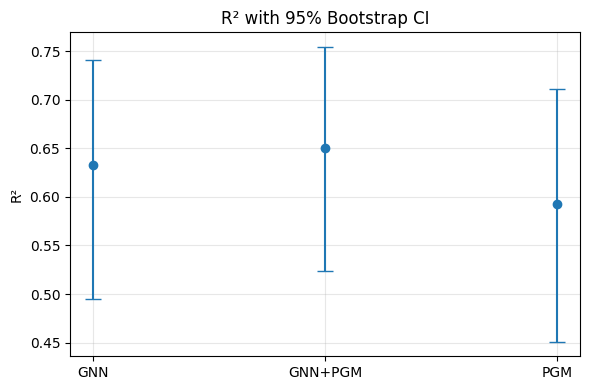

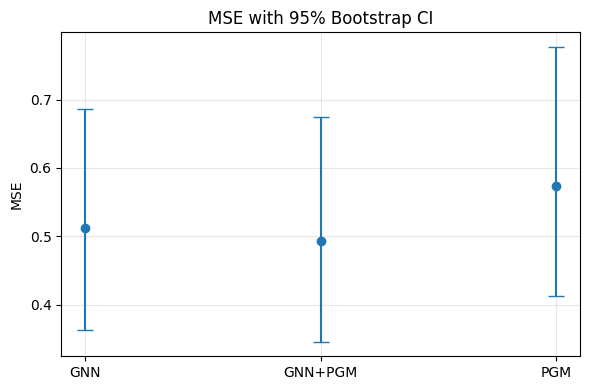

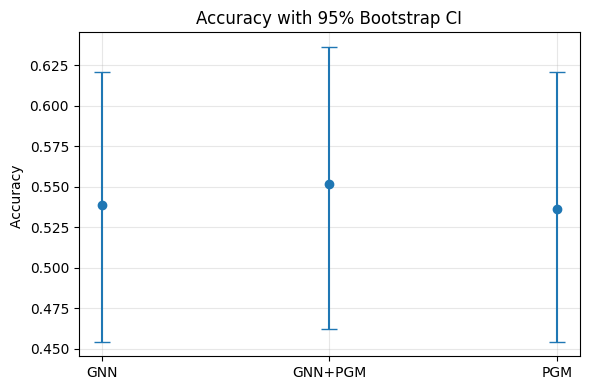

In [18]:
# ==== 95% CIs (bootstrap on test set) + Error-bar plots per metric ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# Reuse: y_test (Series), accuracy_threshold (float),
# and predictions: pgm_preds, gnn_preds, gnn_combined_preds

rng = np.random.default_rng(42)

y_true = np.asarray(y_test, dtype=float)
preds_dict = {
    "PGM": np.asarray(pgm_preds, dtype=float).flatten(),
    "GNN": np.asarray(gnn_preds, dtype=float).flatten(),
    "GNN+PGM": np.asarray(gnn_combined_preds, dtype=float).flatten(),
}

def acc_within(y, p, thr):
    return np.mean(np.abs(p - y) < thr)

def r2_safe(y, p):
    # Avoid undefined R² if y is (near) constant in a bootstrap resample
    if np.allclose(y, y.mean()):
        return 0.0
    return r2_score(y, p)

def bootstrap_metric(y, p, metric_fn, n_boot=2000, rng=None):
    """Percentile bootstrap 95% CI for a scalar metric on paired data."""
    n = len(y)
    idx = np.arange(n)
    stats = np.empty(n_boot, dtype=float)
    for b in range(n_boot):
        res = rng.choice(idx, size=n, replace=True)
        stats[b] = metric_fn(y[res], p[res])
    stats.sort()
    lo = np.percentile(stats, 2.5)
    hi = np.percentile(stats, 97.5)
    mean = float(stats.mean())
    return mean, lo, hi

rows = []
for name, p in preds_dict.items():
    r2_mean, r2_lo, r2_hi = bootstrap_metric(y_true, p, r2_safe, n_boot=2000, rng=rng)
    mse_mean, mse_lo, mse_hi = bootstrap_metric(y_true, p, mean_squared_error, n_boot=2000, rng=rng)
    acc_mean, acc_lo, acc_hi = bootstrap_metric(
        y_true, p, lambda y, q: acc_within(y, q, accuracy_threshold), n_boot=2000, rng=rng
    )
    rows.append({
        "Model": name,
        "R2_mean": r2_mean, "R2_lo": r2_lo, "R2_hi": r2_hi,
        "MSE_mean": mse_mean, "MSE_lo": mse_lo, "MSE_hi": mse_hi,
        "ACC_mean": acc_mean, "ACC_lo": acc_lo, "ACC_hi": acc_hi,
    })

summary_df = pd.DataFrame(rows).sort_values("Model").reset_index(drop=True)
print("\n=== 95% Bootstrap CIs on Test Set ===")
print(summary_df[[
    "Model",
    "R2_mean","R2_lo","R2_hi",
    "MSE_mean","MSE_lo","MSE_hi",
    "ACC_mean","ACC_lo","ACC_hi"
]].round(4))

# --- Error-bar plots (asymmetric) ---
def errorbar_plot(metric, ylabel, title):
    labels = summary_df["Model"].values
    means = summary_df[f"{metric}_mean"].values
    los   = summary_df[f"{metric}_lo"].values
    his   = summary_df[f"{metric}_hi"].values
    yerr  = np.vstack([means - los, his - means])  # asymmetric
    x = np.arange(len(labels))
    plt.figure(figsize=(6,4))
    plt.errorbar(x, means, yerr=yerr, fmt='o', capsize=6)
    plt.xticks(x, labels)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

errorbar_plot("R2",  "R²",  "R² with 95% Bootstrap CI")
errorbar_plot("MSE", "MSE", "MSE with 95% Bootstrap CI")
errorbar_plot("ACC", f'Accuracy ', "Accuracy with 95% Bootstrap CI")
# ==== End CI block ====
